In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm
import PIL.Image as Image
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torch.quantization import QuantStub, DeQuantStub
import numpy as np
import os

In [8]:

class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )
        self.quant = QuantStub()
        self.dequant = DeQuantStub()
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.quant(x)
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        x = self.dequant(x)
        return x

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
convert = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(0.2),
        transforms.ToTensor(),
    ]
)

# dataloader

data = datasets.ImageFolder(root=r"C:\Users\Asus\Documents\deep learning\deep_learn\starters\PetImages", transform=convert)
Loader = DataLoader(data, batch_size=64, shuffle=True)

val_conv = transforms.Compose(
[
    transforms.Resize((128,128)),
    transforms.ToTensor()
])
valid_data = datasets.ImageFolder(r'C:\Users\Asus\Documents\deep learning\deep_learn\starters\PetTest',transform = val_conv)
valid_data_loader = DataLoader(valid_data,batch_size=10,shuffle=True)

MAP = {0: "Cat", 1: "Dog"}

model = AlexNet(2)

# putting model in a training mode
model.train()


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (classifier): Sequential(
    (0): Linear(in_features=12544, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_feat

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 4

TRAIN = True
losses = []

train_data_size = len(Loader)
valid_data_size = len(valid_data_loader)

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    """
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    """

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch + 1, epochs))

        # Set to training mode
        # model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(Loader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

            # print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                # print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

        # Find average training loss and training accuracy
        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc = valid_acc / valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

        epoch_end = time.time()

        print(
            "Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(
                epoch + 1,
                avg_train_loss,
                avg_train_acc * 100,
                avg_valid_loss,
                avg_valid_acc * 100,
                epoch_end - epoch_start,
            )
        )

        # Save if the model has best accuracy till now
        torch.save(model, "TrainLoopImproveCatsDogs.pth")

    return model, history
    


Epoch: 1/4


c:\Users\Asus\Documents\deep learning\deep_learn\lib\site-packages\PIL\TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch : 001, Training: Loss: 44.4183, Accuracy: 3217.2680%, 
		Validation : Loss : 6.9335, Accuracy: 500.0000%, Time: 696.5849s
Epoch: 2/4
Epoch : 002, Training: Loss: 44.3091, Accuracy: 3177.5773%, 
		Validation : Loss : 6.9316, Accuracy: 500.0000%, Time: 713.7401s
Epoch: 3/4
Epoch : 003, Training: Loss: 44.3079, Accuracy: 3200.7732%, 
		Validation : Loss : 6.9321, Accuracy: 500.0000%, Time: 829.0918s
Epoch: 4/4
Epoch : 004, Training: Loss: 44.3647, Accuracy: 3181.9588%, 
		Validation : Loss : 6.9322, Accuracy: 500.0000%, Time: 5422.2979s


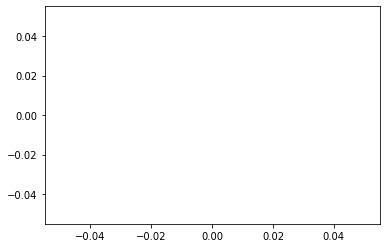

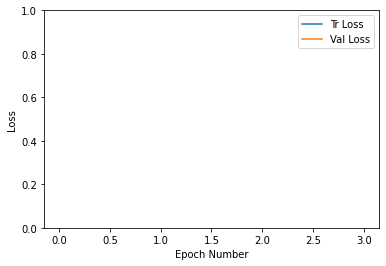

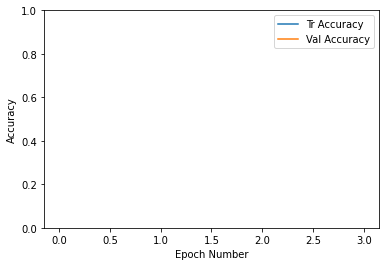

In [11]:
if TRAIN:
    trained_model, history = train_and_validate(model, criterion, optimizer, EPOCHS)
    plt.plot(losses)
    plt.show()
    history = np.array(history)
    plt.plot(history[:, 0:2])
    plt.legend(["Tr Loss", "Val Loss"])
    plt.xlabel("Epoch Number")
    plt.ylabel("Loss")
    plt.ylim(0, 1)
    plt.savefig("_loss_curve.png")
    plt.show()
    plt.plot(history[:, 2:4])
    plt.legend(["Tr Accuracy", "Val Accuracy"])
    plt.xlabel("Epoch Number")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.savefig("_accuracy_curve.png")
    plt.show()
